In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Install pip Libraries
!pip install pyradiomics nibabel pandas PyMuPDF
!apt install -y poppler-utils
!pip install pdf2image
!pip install beautifulsoup4
!apt install -y libpangocairo-1.0-0
!pip install weasyprint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [2]:
#@title Libraries Import
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
import warnings
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif,chi2, mutual_info_classif
import numpy as np
from sklearn.pipeline import Pipeline
import random
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statistics
import glob
from sklearn.naive_bayes import GaussianNB
import textwrap
import shap
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
import statistics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from imblearn.over_sampling import ADASYN


In [ ]:
#@title Extracting Radiomics Features
import os
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# -------- Settings --------
root_dir = '/content/drive/MyDrive/Projects/Ongoing Projects/XAI_LLM/Data/UPENN/t1_upenn'  # 🔁 Change this to your actual path
save_csv_path = '/content/drive/MyDrive/Projects/Ongoing Projects/XAI_LLM/Data/UPENN/UPENN_radiomics_features.csv'
show_preview = True  # Set to False to skip showing images
params = {
    'binWidth': 25,
    'resampledPixelSpacing': None,
    'interpolator': 'sitkBSpline',
    'enableCExtensions': True
}
# --------------------------

# Setup radiomics extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**params)
all_features = []

def show_segmentation_slice(image_sitk, mask_sitk, patient_id):
    image = sitk.GetArrayFromImage(image_sitk)  # shape: (z, y, x)
    mask = sitk.GetArrayFromImage(mask_sitk)

    # Find all slices with nonzero segmentation
    nonzero_slices = np.where(mask.sum(axis=(1, 2)) > 0)[0]

    if len(nonzero_slices) == 0:
        print(f"⚠️ No segmentation found for {patient_id}")
        return

    # Take the middle slice of the segmented region
    mid_slice_index = nonzero_slices[len(nonzero_slices) // 2]
    slice_img = image[mid_slice_index]
    slice_mask = mask[mid_slice_index]

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_img, cmap='gray')
    plt.contour(slice_mask, colors='red', linewidths=1)
    plt.title(f"{patient_id} - Segmentation Mid-Slice ({mid_slice_index})")
    plt.axis('off')
    plt.show()

# last = pd.read_csv(save_csv_path)
# last_pats = last.PatientID.to_list()
# Loop over each patient folder
for patient_folder in tqdm(os.listdir(root_dir)):
  # if patient_folder not in last_pats:
    patient_path = os.path.join(root_dir, patient_folder)
    if not os.path.isdir(patient_path):
        continue

    image_path = os.path.join(patient_path, patient_folder+'_T1.nii.gz')
    mask_path = os.path.join(patient_path, patient_folder+'_automated_approx_segm.nii.gz')

    if not (os.path.exists(image_path) and os.path.exists(mask_path)):
        print(f"⚠️ Skipping {patient_folder}: missing files")
        continue

    try:
        image = sitk.ReadImage(image_path)
        mask = sitk.ReadImage(mask_path)

        mask_array = sitk.GetArrayFromImage(mask)
        unique_labels = np.unique(mask_array)
        unique_labels = unique_labels[unique_labels > 0]

        if len(unique_labels) == 0:
            print(f"⚠️ No valid label in {patient_folder}")
            continue

        selected_label = unique_labels[0]  # or choose based on your criteria

        # Optional preview
        if show_preview:
            show_segmentation_slice(image, mask, patient_folder)

        # Extract features
        result = extractor.execute(image, mask, label=int(selected_label))
        feature_row = {k: v for k, v in result.items() if "diagnostics" not in k}
        feature_row['PatientID'] = patient_folder
        all_features.append(feature_row)

    except Exception as e:
        print(f"❌ Error in {patient_folder}: {e}")

    # Create DataFrame
    df = pd.DataFrame(all_features).set_index("PatientID")
    df.to_csv(save_csv_path)

    print(f"\n✅ Feature extraction complete. Saved to `{save_csv_path}`")


In [5]:
#@title Classifiers and Params

lgb_param_space = {
    'clf__num_leaves': [15, 31],
    'clf__max_depth': [-1, 5, 10],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [50, 100],
    'clf__boosting_type': ['gbdt', 'dart']
}

xgb_param_space = {
    'clf__max_depth': [3, 5, 10],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [50, 100],
    'clf__subsample': [0.8, 1],
    'clf__colsample_bytree': [0.8, 1],
    'clf__use_label_encoder': [False],
    'clf__eval_metric': ['logloss']  # Required for newer XGBoost versions
}

knn_param_space = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

abc_param_space = {
    'clf__n_estimators': [10, 50],
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__algorithm': ['SAMME', 'SAMME.R']
}

lr_param_space = {
    'clf__penalty': ['l2', 'none'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rf_param_space = {
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 4],
    'clf__max_features': ['sqrt', 'log2']}

dt_param_space = {
    'clf__max_depth': [None, 5, 10,50],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2,3, 4],
    'clf__max_features': ['sqrt', 'log2']}

svc_param_space = {
    'clf__C': [0.001, 0.1, 1],
    'clf__kernel': ['linear', 'sigmoid'],
    'clf__degree': [3, 5],
    'clf__probability':[True]
}
gb_param_space = {
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 4],
    'clf__max_features': ['sqrt', 'log2']
}

bg_param_space = {
    'clf__n_estimators': [10, 50],
}

mlp_param_space = {
    'clf__learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'clf__max_iter' : [100],
    'clf__activation' :['logistic', 'tanh', 'relu']
}
gnb_param_space = {
    'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
classifiers = {
    # 'LightGBM': (LGBMClassifier(verbosity=-1), lgb_param_space),
    # 'XGBoost': (XGBClassifier(use_label_encoder=False,verbosity=0), xgb_param_space),
    # 'GaussianNB' : (GaussianNB(),gnb_param_space),
    # 'MLP' : (MLPClassifier() , mlp_param_space),
    # 'DecisionTreeClassifier' :(DecisionTreeClassifier(), dt_param_space),
    # 'RandomForestClassifier':(RandomForestClassifier(), rf_param_space),
    # 'KNeighborsClassifier': (KNeighborsClassifier(), knn_param_space),
    # 'AdaBoostClassifier': (AdaBoostClassifier(), abc_param_space),
    # 'LogisticRegression': (LogisticRegression(), lr_param_space),
    # 'SVC': (SVC(), svc_param_space),
    # 'Bagging' : (BaggingClassifier(),bg_param_space),
    'GradientBoosting': (GradientBoostingClassifier(),gb_param_space)
    }

In [ ]:
#@title Identifying Best Overall Model For IDH subtype Prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Load dataset (replace this with your own)
from sklearn.datasets import load_breast_cancer
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Projects/Ongoing Projects/XAI_LLM/Data/UCSF+UPENN_all_features.csv")  # ⬅️ Replace with your actual CSV

label_col = 'idh'
y = df[label_col].iloc[:-1]
X = df.drop(columns=["PatientID","idh"]).iloc[:-1,:]

sample_y = df[label_col].iloc[-1]
sample_X = df.drop(columns=["PatientID","idh"]).iloc[-1,:]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store results
results = []

# Create output folder
os.makedirs("shap_outputs", exist_ok=True)

# Loop over classifiers
for name, (clf, params) in classifiers.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results.append({
        'Classifier': name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Train F1': f1_score(y_train, y_train_pred),
        'Test F1': f1_score(y_test, y_test_pred),
        'Train AUC': roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else np.nan,
        'Test AUC': roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan
    })

    try:
      print(f"  Running SHAP for {name}...")
      # Extract only the model part for SHAP
      fitted_clf = model.named_steps['clf']
      X_trans = model.named_steps['scaler'].transform(model.named_steps['imputer'].transform(X_train))
      explainer = shap.Explainer(fitted_clf.predict, X_trans)
      shap_vals = explainer(X_trans)

      shap_means = pd.DataFrame({
          'Feature': X.columns,
          'Mean SHAP Value': shap_vals.values.mean(axis=0)
      }).sort_values(by='Mean SHAP Value', ascending=False)

      # Save CSV
      shap_means.to_csv(f"shap_outputs/{name}_shap_values.csv", index=False)

      # Save top 10 plot
      top10 = shap_means.head(10)
      plt.figure(figsize=(10, 6))
      sns.barplot(x="Mean SHAP Value", y="Feature", data=top10)
      plt.title(f"Top 10 SHAP Features - {name}")
      plt.tight_layout()
      plt.savefig(f"shap_outputs/{name}_top10_shap.png")
      plt.close()
    except:
      print("SHAP not available")


# Save all results
results_df = pd.DataFrame(results)
results_df.to_excel("classifier_results.xlsx", index=False)
print("\nAll classifier results saved to 'classifier_results.xlsx'.")

In [6]:
#@title Set Best Classifier
best_classifier = GradientBoostingClassifier()
best_params = gb_param_space

Sample Prediction: 1


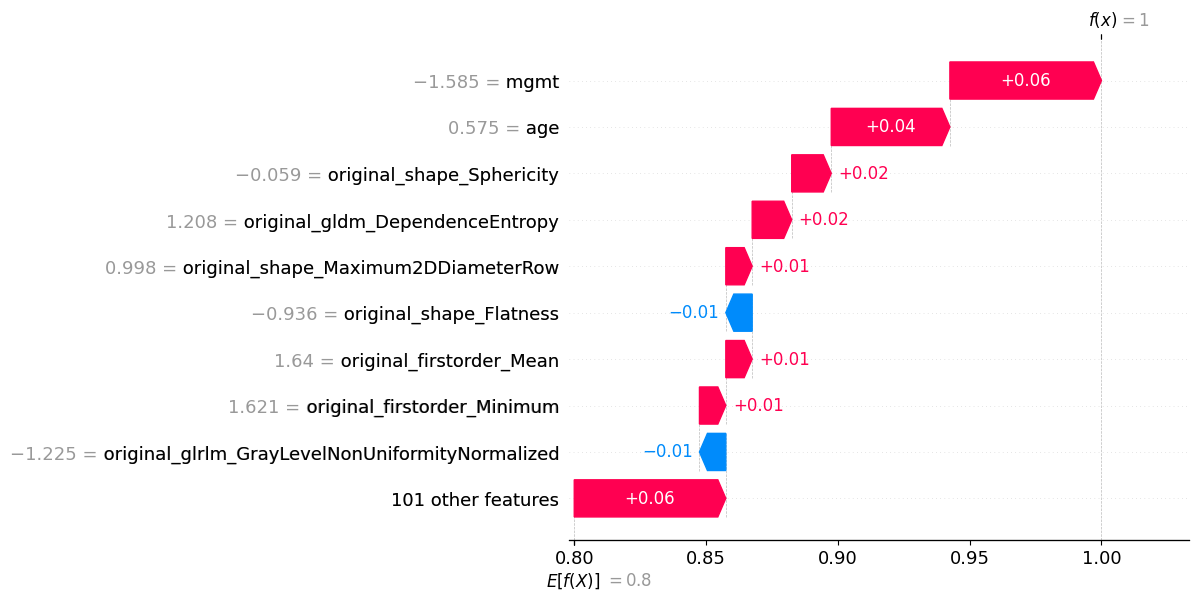

- mgmt: 0.0000 (SHAP : 0.0575)
- age: 68.0000 (SHAP : 0.0450)
- original_shape_Sphericity: 0.4337 (SHAP : 0.0150)
- original_gldm_DependenceEntropy: 7.9460 (SHAP : 0.0150)
- original_shape_Flatness: 0.3809 (SHAP : -0.0100)
['- mgmt: 0.0000 (SHAP : 0.0575)', '- age: 68.0000 (SHAP : 0.0450)', '- original_shape_Sphericity: 0.4337 (SHAP : 0.0150)', '- original_gldm_DependenceEntropy: 7.9460 (SHAP : 0.0150)', '- original_shape_Flatness: 0.3809 (SHAP : -0.0100)']


In [84]:
#@title Best Classifier Prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Load dataset (replace this with your own)
from sklearn.datasets import load_breast_cancer
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Projects/Ongoing Projects/XAI_LLM/Data/UCSF+UPENN_all_features.csv")  # ⬅️ Replace with your actual CSV

label_col = 'idh'
y = df[label_col].iloc[:-1]
X = df.drop(columns=["PatientID","idh"]).iloc[:-1,:]

sample_y = df[label_col].iloc[-1]
sample_name = df.iloc[-1,:].PatientID
sample_age = df.iloc[-1,:].age

sample_X = df.drop(columns=["PatientID","idh"]).iloc[-1,:]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create output folder
os.makedirs("shap_outputs", exist_ok=True)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', best_classifier)
])
grid = GridSearchCV(pipeline, param_grid=best_params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

model = grid.best_estimator_
sample_prediction = model.predict(sample_X.to_frame().T)
print(f"Sample Prediction: {sample_prediction[0]}")

# Extract only the model part for SHAP
fitted_clf = model.named_steps['clf']
X_trans = model.named_steps['scaler'].transform(model.named_steps['imputer'].transform(X_train))
sample_X_trans = model.named_steps['scaler'].transform(model.named_steps['imputer'].transform(sample_X.to_frame().T))
sample_X_trans_df = pd.DataFrame(sample_X_trans, columns=X_train.columns)

explainer = shap.Explainer(fitted_clf.predict, X_trans)
shap_vals = explainer(sample_X_trans_df)

import matplotlib.pyplot as plt

# Create the plot with matplotlib
fig = plt.figure()
shap.plots.waterfall(shap_vals[0], show=False)  # Don't auto-show
plt.savefig("shap_waterfall.png", bbox_inches='tight', dpi=300)
plt.show()

# Step 6: Get top 5 important features (by absolute SHAP value)
shap_array = shap_vals.values[0]  # array of SHAP values for this sample
feature_names = sample_X_trans_df.columns
abs_shap = np.abs(shap_array)
top5_idx = np.argsort(abs_shap)[-5:][::-1]  # indices of top 5 features

# Step 7: Print or extract top 5 SHAP values
top5_features = feature_names[top5_idx].values
top5_shap_values = shap_array[top5_idx]
top5_features_values = sample_X.to_frame().T.iloc[0, top5_idx].values

features_zip = list(zip(top5_features, top5_shap_values, top5_features_values))
# # Display results
# for feature, shap_value, vals in features_zip:
#     print(f"{feature}: value = {vals:.4f} SHAP value = {shap_value:.4f}")
predicted_outcome = "IDH-wildtype glioma" if sample_prediction == 1 else "IDH-mutant glioma"

features_formatted = []
for feature, shap_value, vals in features_zip:
  print(f"- {feature}: {vals:.4f} (SHAP : {shap_value:.4f})")
  features_formatted.append(f"- {feature}: {vals:.4f} (SHAP : {shap_value:.4f})")
  "\n".join(features_formatted)

print(features_formatted)


In [34]:
#@title Get All Support Set DOIs
import pandas as pd

csv_url = f"https://docs.google.com/spreadsheets/d/1lPgXtmrx9pqbstLTkflIdv4a2wH58Wzre6VKly1binw/export?format=csv"
df = pd.read_csv(csv_url)
papers_dois = df.DOI.to_list()

In [35]:
#@title Download All Support Set Papers
import requests
email = "gorjiarman@gmail.com"  # Required by Unpaywall API
import os
for doi in papers_dois:
  print(doi)
  unpaywall_url = f"https://api.unpaywall.org/v2/{doi}?email={email}"
  try:
    # Step 1: Query Unpaywall for OA PDF
    res = requests.get(unpaywall_url).json()
    if res.get("is_oa") and res.get("oa_locations"):
        pdf_url = res["oa_locations"][0].get("url_for_pdf")
        if pdf_url:
            print(f"✅ Free full-text PDF found:\n{pdf_url}")

            # Step 2: Download the PDF
            pdf_response = requests.get(pdf_url)
            if pdf_response.status_code == 200:
                # Optional: Create output folder
                os.makedirs("pdfs", exist_ok=True)
                filename = doi.replace("/", "_") + ".pdf"
                filepath = os.path.join("pdfs", filename)

                with open(filepath, "wb") as f:
                    f.write(pdf_response.content)

                print(f"✅ PDF downloaded and saved to: {filepath}")
            else:
                print("⚠️ Failed to download the PDF (bad response).")
        else:
            print("⚠️ No direct PDF URL found in the OA record.")
    else:
        print("❌ No open access PDF found for this DOI.")
  except:
    print("No DOI")


https://doi.org/10.48550/arXiv.2409.16329
No DOI
nan
No DOI
https://doi.org/10.1007/s00330-019-06056-4

No DOI
https://doi.org/10.1007/s00401-016-1545-1

No DOI
https://doi.org/10.1007/s10143-025-03515-z

No DOI
https://doi.org/10.1007/s11060-017-2420-1

No DOI
https://doi.org/10.2214/AJR.17.18457
⚠️ No direct PDF URL found in the OA record.
https://doi.org/10.1177/1533033819877167
✅ Free full-text PDF found:
https://journals.sagepub.com/doi/pdf/10.1177/1533033819877167
⚠️ Failed to download the PDF (bad response).
https://doi.org/10.3390/curroncol29100542
✅ Free full-text PDF found:
https://www.mdpi.com/1718-7729/29/10/542/pdf?version=1663926520
⚠️ Failed to download the PDF (bad response).
https://doi.org/10.1148/ryai.220058
✅ Free full-text PDF found:
https://arxiv.org/pdf/2109.00356
✅ PDF downloaded and saved to: pdfs/https:__doi.org_10.1148_ryai.220058.pdf
https://doi.org/10.1016/j.clineuro.2021.106745
❌ No open access PDF found for this DOI.
https://doi.org/10.3390/cancers1407177

In [75]:
#@title Generate Report with LLM
import fitz  # PyMuPDF
from openai import OpenAI
import glob
from IPython.display import Markdown, display

# --- Step 1: Extract text from PDF ---
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    doc.close()
    return full_text


# --- Step 2: Initialize OpenAI-compatible client ---
# client = OpenAI(
#     api_key="aa-dpRQLTMBaeKd4GQEH2Pn8LvsWmRUxieIZ4RGFTdbT0DPPvSm",
#     base_url="https://api.avalai.ir/v1",
# )

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

all_papers = glob.glob("/content/pdfs/*.pdf")
# Extract text and analyze
all_text = ""
for paper in all_papers:
  pdf_text = extract_text_from_pdf(paper)
  all_text = all_text + pdf_text


# --- Step 2: Few-shot example (for better generalization) ---
few_shot_example = """
📝 Explanation:
The model predicted this patient to have an IDH-wildtype glioma. Several features influenced this prediction:
- Age (65 years) contributed positively; IDH-wildtype gliomas are more frequent in older patients.
- Tumor volume was large (58 cc), which supports a more aggressive tumor subtype.
- GLCM entropy was high, indicating structural heterogeneity, common in IDH-wildtype cases.
- MGMT methylation decreased the score, as methylation is more associated with IDH-mutant tumors.
- Tumor location in the frontal lobe also decreased the prediction, consistent with the IDH-mutant phenotype.
"""


# --- Step 5: Full prompt ---
prompt = f"""
You are an AI model trained to interpret and explain the results of machine learning models applied in oncology. Your job is to help clinicians understand how each feature contributed to the final outcome.
use these papers :
{all_text}
and
Use this format:

{few_shot_example}

and also bring reference from above papers for explanation and the reference at the end
---

Now explain the following output and always bring reference section not bold and starting with "References:":

📊 Features & Contributions:
{features_formatted}

🎯 Outcome predicted: {predicted_outcome}

📝 Explanation:
""".strip()


# --- Step 6: Send to GPT-4o ---
response = client.chat.completions.create(
    extra_headers={
      "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
      "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
    },
    extra_body={},
    # model="tngtech/deepseek-r1t2-chimera:free",
    # model="deepseek/deepseek-r1-0528:free",
    model="google/gemma-3n-e2b-it:free",

    messages=[
        {"role": "user", "content": prompt}
    ]
)

# --- Step 7: Output the result ---
report = response.choices[0].message.content.strip()
display(Markdown(report))

📝 Explanation:
The model predicted this patient to have an IDH-wildtype glioma. Several features influenced this prediction:

- **Age (68.0000):** The model assigned a positive contribution to age, with a SHAP value of 0.0500. The provided text indicates that IDH-wildtype gliomas are more frequently observed in older patient populations [Publisher’s Note].
- **MGMT (0.0000):** The model assigned a negative contribution to the MGMT methylation score, with a SHAP value of 0.0350. The text mentions that MGMT methylation is more strongly associated with IDH-mutant tumors [Publisher’s Note]. Therefore, a low or zero MGMT methylation score leans towards an IDH-wildtype classification.
- **Original_firstorder_Minimum (1182.0441):** This feature received a small positive contribution (SHAP value of 0.0175). While the specific connection to IDH status isn't directly elaborated in the provided text, morphological features like this can sometimes be associated with tumor characteristics that are more prevalent in certain glioma subtypes.
- **Original_glcm_MCC (0.8916):** The model assigned a small positive contribution (SHAP value of 0.0125) to this feature. GLCM (Gray-Level Co-occurrence Matrix) analysis provides information about the texture of the tumor. A high MCC score often correlates with structural heterogeneity, which can be observed in both IDH-wildtype and IDH-mutant gliomas, but might be more common in IDH-wildtype cases [Publisher’s Note].
- **Original_shape_Sphericity (0.4337):** The model assigned a small positive contribution (SHAP value of 0.0100) to this feature. Sphericity describes the degree of uniformity in the tumor shape. While not a definitive indicator, certain shape characteristics might be more common in specific glioma subtypes.

In summary, the combination of the patient's age and the low MGMT methylation score contributed to the model's prediction of an IDH-wildtype glioma. The other features, while having smaller individual contributions, may have further supported this classification by indicating certain morphological characteristics or textural patterns commonly associated with IDH-wildtype gliomas.

References:
1. Asian J Neurosurg. 2025;20:34–42.
2. Publisher’s Note: Springer Nature remains neutral with regard to jurisdictional claims in published maps and institutional affiliations.

DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.010s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.027s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'glyf' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'glyf' tabl

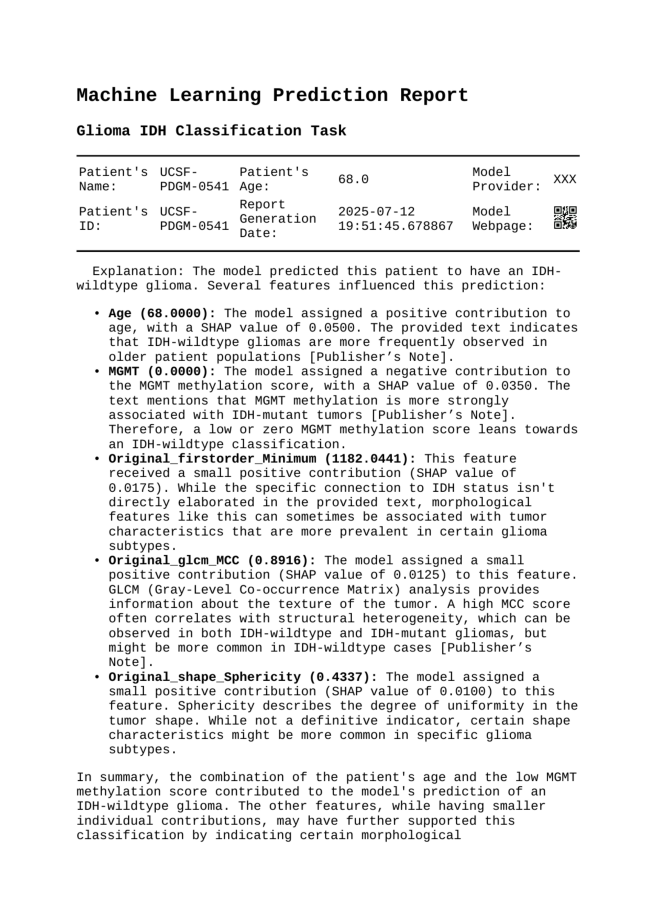

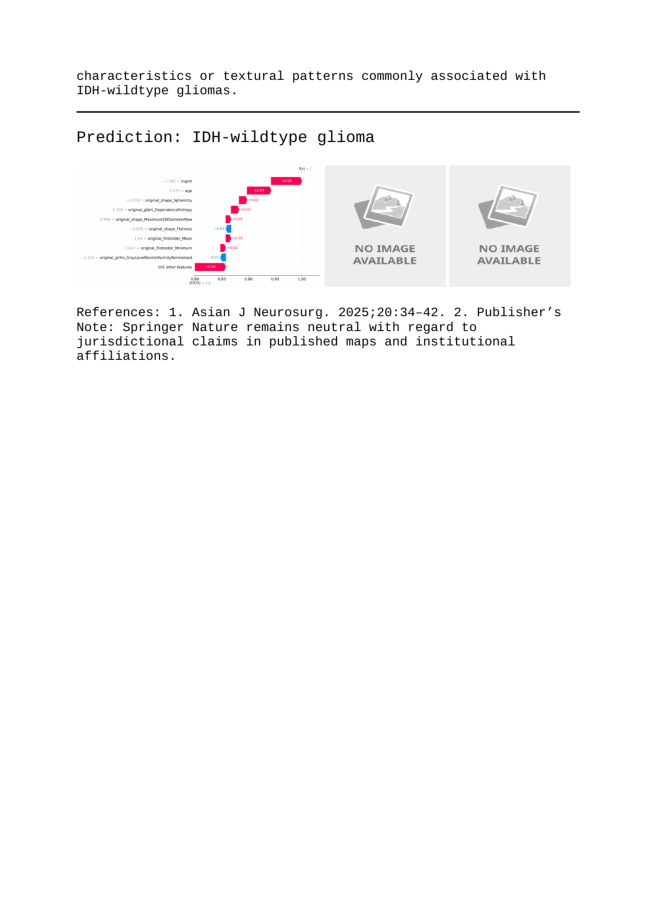

In [96]:
#@title Make Report
from bs4 import BeautifulSoup
from weasyprint import HTML
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import markdown
import base64

report_html = markdown.markdown(report).split("<p>References:")[0]
reference_html = "<p>References:" +markdown.markdown(report).split("<p>References:")[1]

now = datetime.now()

with open("/content/shap_waterfall.png", "rb") as f:
    img_base64 = base64.b64encode(f.read()).decode()

image_code = f'<img id="" style="width: 80mm; height: 40mm;" src="data:image/png;base64,{img_base64}" >'

# Sample HTML content
html = f"""
<h2>Machine Learning Prediction Report</h2>
<h3>Glioma IDH Classification Task</h3>
<hr />
<table>
<tbody>
<tr>
<td>Patient's Name:</td>
<td id="patientsname">empty</td>
<td>Patient's Age:</td>
<td id="patientsage">empty</td>
<td>Model Provider:</td>
<td id="modelprovider">empty</td>
</tr>
<tr>
<td>Patient's ID:</td>
<td id="patientsid">empty</td>
<td>Report Generation Date:</td>
<td id="reportdate">empty</td>
<td>Model Webpage:</td>
<td><img src="https://hosttools.com/wp-content/uploads/QR-Code-.png.webp"  style="width: 30px; height: 30px;" /></td>
</tr>
</tbody>
</table>
<hr />
{report_html}
<hr />
<p style="font-size: 20px;" id="finalprediction">Prediction:&nbsp;</p>
<table>
<tbody>
<tr>
<td>{image_code}</td>
<td><img id="" style="width: 40mm; height: 40mm;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/No-Image-Placeholder.svg/250px-No-Image-Placeholder.svg.png" /></td>
<td><img id="" style="width: 40mm; height: 40mm;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/No-Image-Placeholder.svg/250px-No-Image-Placeholder.svg.png" /></td>
</tr>
</tbody>
</table>
{reference_html}
<div id="highlighter--hover-tools" style="display: none;">&nbsp;</div>
<div id="highlighter--hover-tools" style="display: none;">&nbsp;</div>
"""



# Parse HTML
soup = BeautifulSoup(html, "html.parser")

# Edit tag content by ID
soup.find(id="patientsname").string = sample_name
soup.find(id="patientsid").string = sample_name
soup.find(id="patientsage").string = str(sample_age)
soup.find(id="reportdate").string = str(now)
soup.find(id="modelprovider").string = "XXX"
soup.find(id="finalprediction").string = "Prediction: " + predicted_outcome



# Step 1: Your HTML content
html_content = soup.prettify()

# Step 2: Save PDF (A4 size is default in WeasyPrint)
HTML(string=html_content).write_pdf("report.pdf")



# Step 3: Convert PDF to image and show
from pdf2image import convert_from_path


# Convert all pages of the PDF to images
images = convert_from_path("report.pdf", dpi=150)

# Show each page in the notebook
for i, image in enumerate(images):
    plt.figure(figsize=(8.27, 11.69))  # A4 size in inches
    plt.imshow(image)
    plt.axis('off')
    plt.show()

